In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad


In [19]:
# gauss legendre quadrature nodes and weights via
# Newton iteration
def lgwt(N,a,b):
    """
    This script is for computing definite integrals using Legendre-Gauss
    Quadrature. Computes the Legendre-Gauss nodes and weights on an interval
    [a,b] with truncation order N
    Suppose you have a continuous function f(x) which is defined on [a,b]
    which you can evaluate at any x in [a,b]. Simply evaluate it at all of
    the values contained in the x vector to obtain a vector f. Then compute
    the definite integral using np.sum(f*w)
    Written by Greg von Winckel - 02/25/2004
    translated to Python - 10/30/2022
    """
    N = N-1
    N1 = N+1
    N2 = N+2
    eps = np.finfo(float).eps
    xu = np.linspace(-1,1,N1)
    # Initial guess
    y = np.cos((2*np.arange(0,N1)+1)*np.pi/(2*N+2))+(0.27/N1)*np.sin(np.pi*xu*N/N2)
    # Legendre-Gauss Vandermonde Matrix
    L = np.zeros((N1,N2))
    # Compute the zeros of the N+1 Legendre Polynomial
    # using the recursion relation and the Newton-Raphson method
    y0 = 2.
    one = np.ones((N1,))
    zero = np.zeros((N1,))
    # Iterate until new points are uniformly within epsilon of old points
    while np.max(np.abs(y-y0)) > eps:
        L[:,0] = one
        L[:,1] = y
        for k in range(2,N1+1):
            L[:,k] = ((2*k-1)*y*L[:,k-1]-(k-1)*L[:,k-2])/k
        lp = N2*(L[:,N1-1]-y*L[:,N2-1])/(1-y**2)
        y0 = y
        y = y0-L[:,N2-1]/lp
    # Linear map from[-1,1] to [a,b]
    x=(a*(1-y)+b*(1+y))/2
    # Compute the weights
    w=(b-a)/((1-y**2)*lp**2)*(N2/N1)**2
    return x, w

In [30]:
# adaptive quad subroutines
# the following three can be passed
# as the method parameter to the main adaptive_quad() function

def eval_composite_trap(M, a, b, f):
    """
    put code from prelab with same returns as gauss_quad
    you can return None for the weights
    """
    h = (b - a)/M
    x = lgwt(M, a, b)[0]
    w = None
    
    func = 0
    for i in range(1, M):
        func += f(x[i])
        
    
    I_hat = h/2 * (f(a) + 2*func + f(b))
    return I_hat, x, None

def eval_composite_simpsons(M, a, b, f):
    """
    put code from prelab with same returns as gauss_quad
    you can return None for the weights
    """
    h = (b - a)/M
    x, w = lgwt(M, a, b)
    n1 = int(M/2 - 1)
    n2 = int(M/2)
    x1 = x[::2]
    x2 = x[1::2]

    func1 = 0
    func2 = 0
    for i in range(n1):
        func1 += f(x1[i])
    for i in range(n2):
        func2 += f(x2[i])
        
    I_hat = h/3 * (f(a) + 2*func1 + 4*func2 + f(b))    
        
    return I_hat, x, None
    

def eval_gauss_quad(M, a, b, f):
    """
    Non-adaptive numerical integrator for \int_a^b f(x)w(x)dx
    Input:
    M - number of quadrature nodes
    a,b - interval [a,b]
    f - function to integrate

    Output:
    I_hat - approx integral
    x - quadrature nodes
    w - quadrature weights

    Currently uses Gauss-Legendre rule
    """
    x, w = lgwt(M, a, b)
    I_hat = np.sum(f(x)*w)
    return I_hat, x, w

def adaptive_quad(a, b, f, tol, M, method):
    """
    Adaptive numerical integrator for \int_a^b f(x)dx

    Input:
    a,b - interval [a,b]
    f - function to integrate
    tol - absolute accuracy goal
    M - number of quadrature nodes per bisected interval
    method - function handle for integrating on subinterval
         - eg) eval_gauss_quad, eval_composite_simpsons etc.

    Output: I - the approximate integral
          X - final adapted grid nodes
          nsplit - number of interval splits
    """
    # 1/2^50 ~ 1e-15
    maxit = 50
    left_p = np.zeros((maxit,))
    right_p = np.zeros((maxit,))
    s = np.zeros((maxit,1))
    left_p[0] = a; right_p[0] = b;
    # initial approx and grid
    s[0],x,_ = method(M,a,b,f);
    # save grid
    X = []
    X.append(x)
    j = 1;
    I = 0;
    nsplit = 1;
    while j < maxit:
        # get midpoint to split interval into left and right
        c = 0.5*(left_p[j-1]+right_p[j-1]);
        # compute integral on left and right spilt intervals
        s1,x,_ = method(M, left_p[j-1], c, f); X.append(x)
        s2,x,_ = method(M, c, right_p[j-1], f); X.append(x)
        if np.max(np.abs(s1+s2-s[j-1])) > tol:
            left_p[j] = left_p[j-1]
            right_p[j] = 0.5*(left_p[j-1]+right_p[j-1])
            s[j] = s1
            left_p[j-1] = 0.5*(left_p[j-1]+right_p[j-1])
            s[j-1] = s2
            j = j+1
            nsplit = nsplit+1
        else:
            I = I+s1+s2
            j = j-1
            if j == 0:
                j = maxit
                
    return I, np.unique(X), nsplit


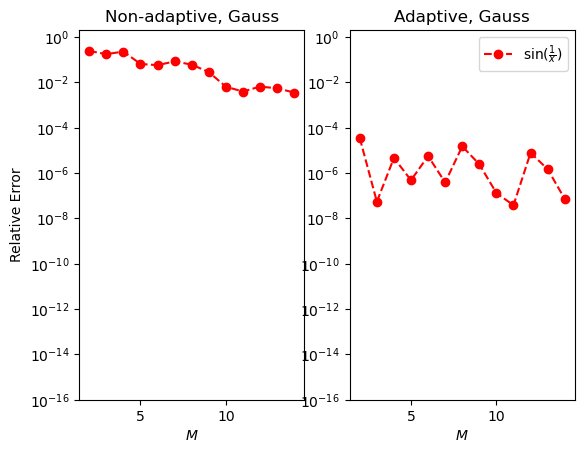

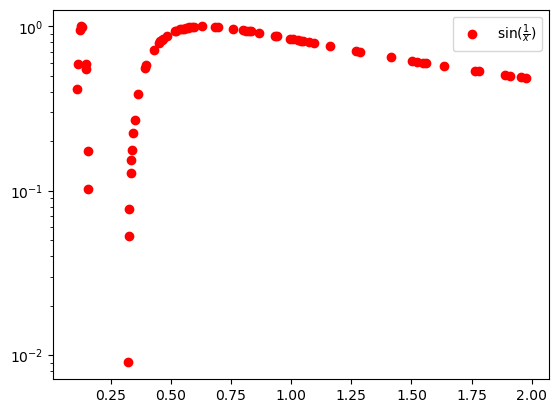

In [42]:
# This script tests the convergence of adaptive quad 
# and compares to a non adaptive routine

# get adaptive_quad routine and numpy from adaptive_quad.py
#from adaptive_quad import *
# get plot routines
import matplotlib.pyplot as plt

# specify the quadrature method 
# (eval_gauss_quad, eval_composite_trap, eval_composite_simpsons)
method1 = eval_gauss_quad
method2 = eval_composite_trap
method3 = eval_composite_simpsons

# interval of integration [a,b]
a = 0.1; b = 2
# function to integrate and true values
# TRYME: uncomment and comment to try different funcs
#        make sure to adjust I_true values if using different interval!
#f = lambda x: np.log(x)**2; I_true = 2; labl = '$\log^2(x)$'
#f = lambda x: 1./(np.power(x,(1./5.))); I_true = 5./4.; labl = '$\\frac{1}{x^{1/5}}$'
#f = lambda x: np.exp(np.cos(x)); I_true = 2.3415748417130531; labl = '$\exp(\cos(x))$'
#f = lambda x: x**20; I_true = 1./21.; labl = '$x^{20}$'
# below is for a=0.1, b = 2
f = lambda x: np.sin(1./x); I_true = 1.1455808341; labl = r'$\sin(\frac{1}{x})$'

# absolute tolerance for adaptive quad 
tol = 1e-3
# machine eps in numpy
eps = np.finfo(float).eps

# number of nodes and weights, per subinterval 
Ms = np.arange(2,15); nM = len(Ms)
# storage for error
err_old = np.zeros((nM,))
err_new = np.zeros((nM,))

method = method1
# loop over quadrature orders
# compute integral with non adaptive and adaptive
# compute errors for both 
for iM in range(nM):
    M = Ms[iM]; 
    # non adaptive routine 
    # Note: the _,_ are dummy vars/Python convention 
    # to store uneeded returns from the routine
    I_old,_,_ = method1(M,a,b,f)
    # adaptive routine
    I_new, X, nsplit = adaptive_quad(a, b, f, tol, M, method)
    err_old[iM] = np.abs(I_old-I_true)/I_true
    err_new[iM] = np.abs(I_new-I_true)/I_true 
    # clean the error for nice plots
    if err_old[iM] < eps:
        err_old[iM] = eps 
    if err_new[iM] < eps:
        err_new[iM] = eps
    # save grids for M = 2
    if M == 5:
        mesh = X
    
  
# plot the old and new error for each f and M
fig,ax = plt.subplots(1,2)
ax[0].semilogy(Ms,err_old,'ro--')
ax[0].set_ylim([1e-16,2]);
ax[0].set_xlabel('$M$')
ax[0].set_title('Non-adaptive, Gauss')
ax[0].set_ylabel('Relative Error');
ax[1].semilogy(Ms,err_new,'ro--',label=labl)
ax[1].set_ylim([1e-16,2]);
ax[1].set_xlabel('$M$')
ax[1].set_title('Adaptive, Gauss')
ax[1].legend()
plt.show()

# plot the adaptive mesh for M=2
fig,ax = plt.subplots(1,1)
ax.semilogy(mesh,f(mesh),'ro',label=labl)
ax.legend()
plt.show()

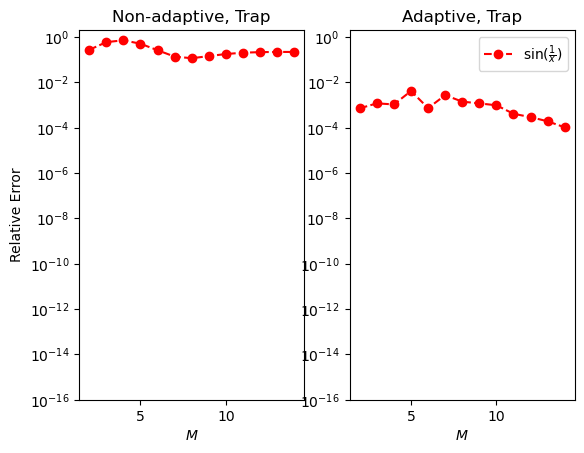

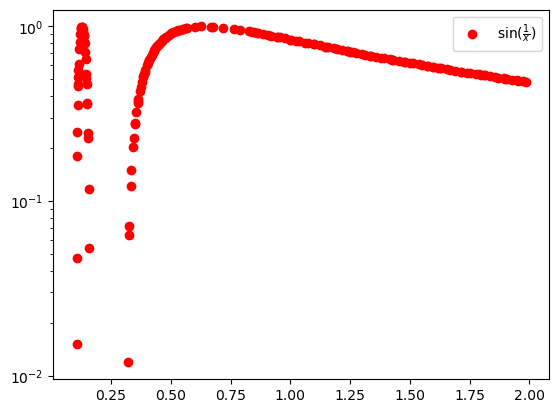

In [39]:
# loop over quadrature orders
# compute integral with non adaptive and adaptive
# compute errors for both 
method = method2
for iM in range(nM):
    M = Ms[iM]; 
    # non adaptive routine 
    # Note: the _,_ are dummy vars/Python convention 
    # to store uneeded returns from the routine
    I_old,_,_ = method(M,a,b,f)
    # adaptive routine
    I_new, X, nsplit = adaptive_quad(a, b, f, tol, M, method)
    err_old[iM] = np.abs(I_old-I_true)/I_true
    err_new[iM] = np.abs(I_new-I_true)/I_true 
    # clean the error for nice plots
    if err_old[iM] < eps:
        err_old[iM] = eps 
    if err_new[iM] < eps:
        err_new[iM] = eps
    # save grids for M = 2
    if M == 5:
        mesh = X
    
  
# plot the old and new error for each f and M
fig,ax = plt.subplots(1,2)
ax[0].semilogy(Ms,err_old,'ro--')
ax[0].set_ylim([1e-16,2]);
ax[0].set_xlabel('$M$')
ax[0].set_title('Non-adaptive, Trap')
ax[0].set_ylabel('Relative Error');
ax[1].semilogy(Ms,err_new,'ro--',label=labl)
ax[1].set_ylim([1e-16,2]);
ax[1].set_xlabel('$M$')
ax[1].set_title('Adaptive, Trap')
ax[1].legend()
plt.show()

# plot the adaptive mesh for M=2
fig,ax = plt.subplots(1,1)
ax.semilogy(mesh,f(mesh),'ro',label=labl)
ax.legend()
plt.show()

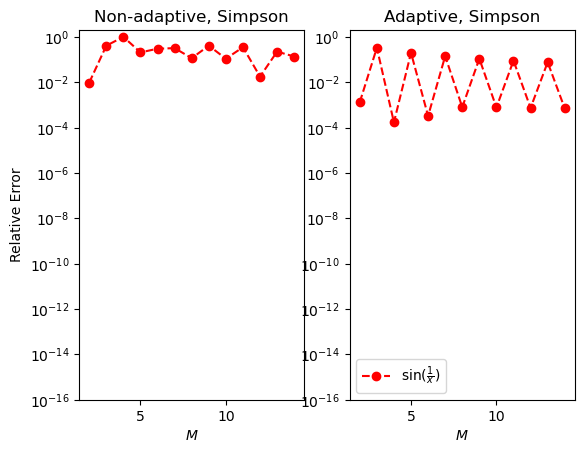

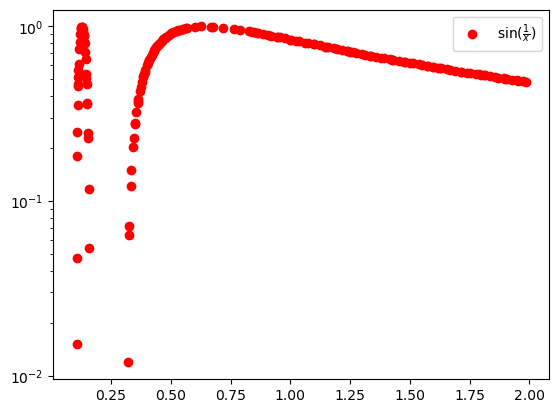

In [41]:
# loop over quadrature orders
# compute integral with non adaptive and adaptive
# compute errors for both 
method = method3
for iM in range(nM):
    M = Ms[iM]; 
    # non adaptive routine 
    # Note: the _,_ are dummy vars/Python convention 
    # to store uneeded returns from the routine
    I_old,_,_ = method(M,a,b,f)
    # adaptive routine
    I_new, X, nsplit = adaptive_quad(a, b, f, tol, M, method)
    err_old[iM] = np.abs(I_old-I_true)/I_true
    err_new[iM] = np.abs(I_new-I_true)/I_true 
    # clean the error for nice plots
    if err_old[iM] < eps:
        err_old[iM] = eps 
    if err_new[iM] < eps:
        err_new[iM] = eps
    # save grids for M = 2
    if M == 5:
        mesh = X
    
  
# plot the old and new error for each f and M
fig,ax = plt.subplots(1,2)
ax[0].semilogy(Ms,err_old,'ro--')
ax[0].set_ylim([1e-16,2]);
ax[0].set_xlabel('$M$')
ax[0].set_title('Non-adaptive, Simpson')
ax[0].set_ylabel('Relative Error');
ax[1].semilogy(Ms,err_new,'ro--',label=labl)
ax[1].set_ylim([1e-16,2]);
ax[1].set_xlabel('$M$')
ax[1].set_title('Adaptive, Simpson')
ax[1].legend()
plt.show()

# plot the adaptive mesh for M=2
fig,ax = plt.subplots(1,1)
ax.semilogy(mesh,f(mesh),'ro',label=labl)
ax.legend()
plt.show()